In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
import joblib

In [4]:
# 2. Load Dataset
df = pd.read_csv("../data/diabetes_dataset.csv")  # path relative to notebooks folder
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# 3. Explore Data

print("Shape:", df.shape)
print(df.info())
print(df.describe())
print("Missing values:\n", df.isnull().sum())

Shape: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.7

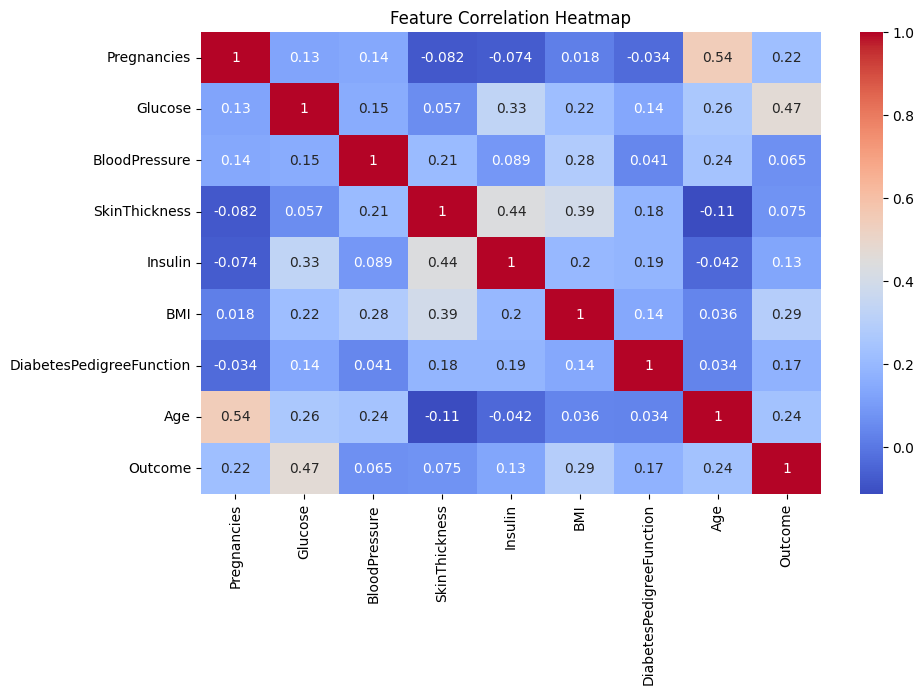

In [6]:
# 4. Visualizations

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


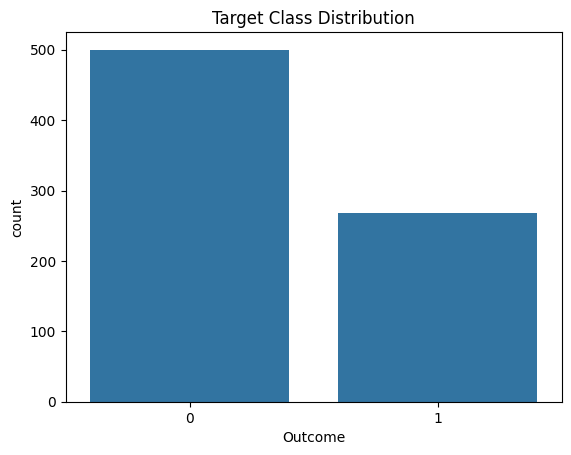

In [7]:
# Class distribution
sns.countplot(x=df['Outcome'])  # Assuming Outcome is target
plt.title("Target Class Distribution")
plt.show()


# 5. Define Features and Target

X = df.drop(columns=["Outcome"])  # Replace 'Outcome' with actual target column name if different
y = df["Outcome"]

# Numeric columns only (diabetes dataset has no categoricals by default)
num_cols = X.columns.tolist()

In [8]:

# 6. Preprocessing Pipeline

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols)
])


In [9]:
# 7. Model Definitions

log_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

rf_clf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])


In [10]:

# 8. Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 9. Cross-Validation Performance

for model, name in [(log_reg, "Logistic Regression"), (rf_clf, "Random Forest")]:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    print(f"{name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Logistic Regression CV Accuracy: 0.7785 ± 0.0126
Random Forest CV Accuracy: 0.7655 ± 0.0336



Logistic Regression Performance:
Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154

ROC AUC: 0.8229629629629629


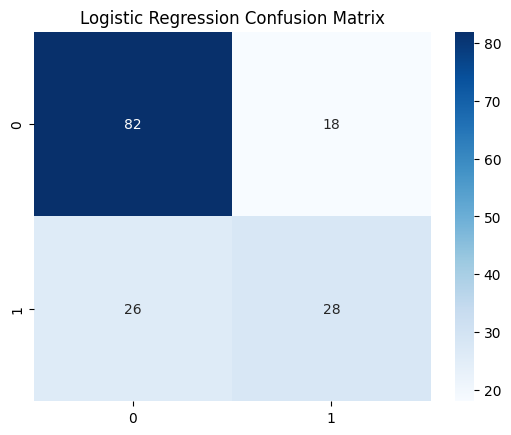


Random Forest Performance:
Accuracy: 0.7597402597402597
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.68      0.59      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154

ROC AUC: 0.8147222222222222


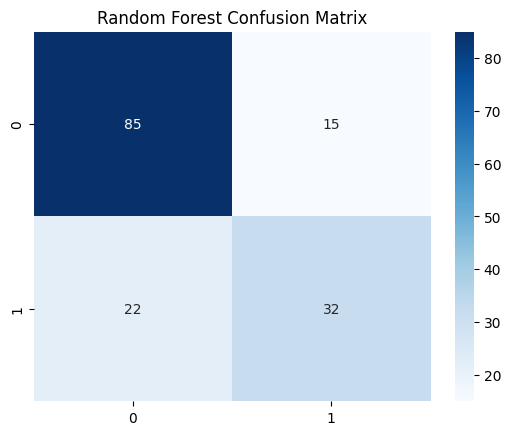

In [11]:
# 10. Fit Final Models

log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)


# 11. Evaluation

def evaluate_model(name, y_true, y_pred, model):
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    if hasattr(model, "predict_proba"):
        auc = roc_auc_score(y_true, model.predict_proba(X_test)[:, 1])
        print("ROC AUC:", auc)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

evaluate_model("Logistic Regression", y_test, y_pred_lr, log_reg)
evaluate_model("Random Forest", y_test, y_pred_rf, rf_clf)


In [12]:
# 12. Choose Best Model

# Compare based on accuracy or AUC
lr_acc = accuracy_score(y_test, y_pred_lr)
rf_acc = accuracy_score(y_test, y_pred_rf)

best_model = rf_clf if rf_acc >= lr_acc else log_reg
print(f"Best model: {'Random Forest' if best_model == rf_clf else 'Logistic Regression'}")

# 13. Save Model

joblib.dump(best_model, "../model.pkl")
print("Model saved to ../model.pkl")

Best model: Random Forest
Model saved to ../model.pkl
